In [3]:
from google.colab import drive
drive.mount("ndrive")

Drive already mounted at ndrive; to attempt to forcibly remount, call drive.mount("ndrive", force_remount=True).


In [4]:
cd 'ndrive/My Drive/assignment'

/content/ndrive/My Drive/assignment


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_sample_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from skimage import io, transform
import tensorflow as tf
import pickle as pk
from sklearn.impute import SimpleImputer

## **Assuming metadata file exist in *current* folder.**

In [0]:
metaData = pd.read_csv("HAM10000_metadata.csv")

lesion_types = {
        'nv': 'Melanocytic nevus',
        'mel':'Melanoma',
        'bkl':'Benign keratosis',
        'bcc':'Basal cell carcinoma',    
        'akiec':'Actinic keratosis',
        'vasc':'Vascular lesion',
        'df':'Dermatofibroma'
        }


**Encoder used for labeling data and saving model for future reference.**

In [0]:

lEncoder = LabelEncoder()
lEncoder.fit(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
metaData['encoded_dx'] = lEncoder.transform(metaData['dx'])
pk.dump(lEncoder,open("encoder.pkl","wb"))
#dumping encoder for use in future

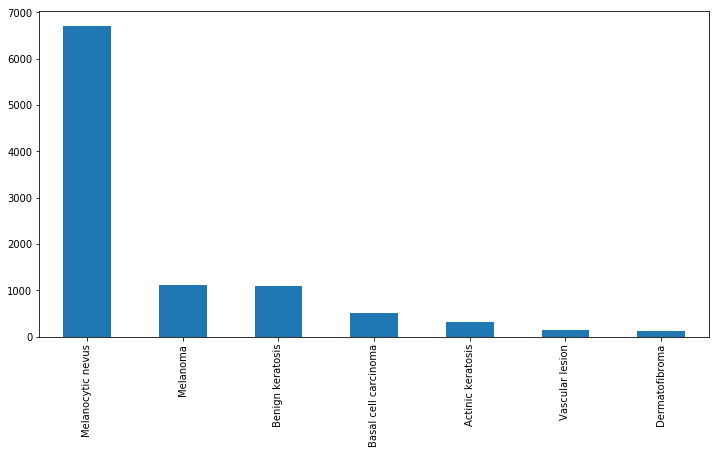

In [8]:
fig, axes = plt.subplots(1,1,figsize=(12,6))
metaData['dx'].map(lesion_types.get).value_counts().plot(kind="bar", ax=axes)

# From the graph it's very much clear that data is very Skewed and minority class should be oversampled for good results.
Steps that i followed for this problem:

**Approaches that I was able to apply in the alloted time frame.**
1. Develope a very basic CNN model with two CNN layers, one pooling layer and  2 dense layers. This design I have used hyperparamete **dropout** layers and **learning rate**. I used inverse scaling technique and gradually reduced **learning rate** for better results and faster training.

2. I also observed a pattern, where images have actual content on the centre always. **For me its ok to loose corner data as it does not contain much information and hence used padding="VALID". It makes model training bit faster and also solves the problem of out of memory, which I observed even in Google Colaboratory at that time I was trying batch size of 100 images.**

3. Then i analyses various online formus as well for similar problem. But observed that none of the forum is using **Meta Data**. For me meta data is also relevant information for liasion detection. I clubbed **Meta Data**, infomration with the **Dense Layer and observed bit better result than the normal model.** 
**Note:** A substitute as mentioned in 6.

**Approaches which are still pending for evaluation**
4. Data is skewed, and except "Melanocytic nevus", every image collection should required oversampling for non-biased results. **I explored Keras image preprocessing Class ImageDataGenerator**.
for image augumentation. **But the limitation with this approach, I can't get MetaData for oversampled images and hence cannt use approach 3 along with augumented images**

5. I develope a CNN layer's but we have many very well trained and proven CNN networks like MobileNet. Should be try with this as well.

6. Ensemble technique. Instead of merging meta data with the convoluted image data, create two DNN model.
     * Regular CNN model as mentioned in step 1.
     * DNN model with meta data.
   



In [0]:

y = metaData['encoded_dx']
df_train, df_test = train_test_split(metaData, test_size=0.1, random_state=786, stratify=y)


***transformation*** default is False, if set as true will rescale image by 1/4. I didnt get a chance to try with rescaled image.
Since we have to analyse different type of liasion closely, image scaling will not be that much helpful.

**Image data normalization and ensure that it always in a scale of between (0,1) and hence simily multiply each pixel by 1/255.**

# Assumption all the images exist under *images* folder.
Though image dimensions are same for all the images, still put a safe check and converted back to 450*600.


```
#if(450 != img.shape[0] or 600 != img.shape[1]):
#  img = transform.resize(img, (450, 600),anti_aliasing=True)
```



In [0]:
def get_batch(df, batch_size, transformation = False):
    """
    tranformation: Set as False just to get the original image. Tried to run,
    but observed memory issue. Set can set as True and reduced scale  by 1/4.
    """
    for batch_i in range(0, 1 + (df.shape[0] //batch_size)):
        start_i = batch_i * batch_size
        try:
            batch = df.iloc[start_i:start_i + batch_size]    
        except IndexError:
            batch = df.loc[start_i:]
        image_list  = [] 
        label = []
        
        for i in range(batch.shape[0]):
            imageFileName = batch.iloc[i]['image_id']
            try:
                img = io.imread('images/'+imageFileName+".jpg", plugin='matplotlib')
                #if(450 != img.shape[0] or 600 != img.shape[1]):
                #  img = transform.resize(img, (450, 600),anti_aliasing=True)
                if True == transformation:
                    img = transform.rescale(img, 0.25, anti_aliasing=True)
                    #Recommended to use anti_aliasing as True just to have crisp boundaries of the image.
                image_list.append(img/255)
                #Normalizing image data
                
                label.append(batch.iloc[i]['encoded_dx'])
            
            except IOError:
                pass
        yield np.array(image_list), np.array(label)   

Most of the placeholder's are self explanatory. 

**is_model_training**, is used to set whether model is used for training or prediction, so that we can drop the usage of **dropout** layer.

In [0]:
def modelInputs(height, width, chanels):
    '''Create palceholders for inputs to the model'''
    features = tf.placeholder(tf.float32, shape=[None, height, width, channels],
                              name="features")    
    target = tf.placeholder(tf.int32, shape=[None], name="target")
    lr = tf.placeholder(tf.float32, name='lr')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    is_model_training = tf.placeholder(tf.bool, name = "is_model_training")
    return features, target, lr, keep_prob, is_model_training

Have used **Dropuout layer** for taining phase and minimizing overfitting.  Also introduced **pooling for conv2 layer.**

In [0]:
def convLayersWithPooling(features, keep_prob, conv1_FiltersCount, conv2_FiltersCount, 
                          conv1_filterSize, conv2_filterSize, conv1_stride, conv2_stride, 
                          conv1_pad, conv2_pad, denseLayerNeurons, outputSize, isTraining):
    with tf.name_scope("ConvLayers"):
        conv1 = tf.layers.conv2d(features, filters=conv1_FiltersCount, kernel_size=conv1_filterSize,
                             strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, name="conv1")
        conv2 = tf.layers.conv2d(conv1, filters=conv2_FiltersCount, kernel_size=conv2_filterSize,
                             strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, name="conv2")
    with tf.name_scope("Pooling"):
        layer3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        layer3_reshaped = tf.reshape(layer3, shape=[-1, layer3.shape[1]* layer3.shape[2]* layer3.shape[3]])
        
    with tf.name_scope("DenseLayer"):
        layer4 = tf.layers.dense(layer3_reshaped, denseLayerNeurons, activation=tf.nn.relu, 
                                 name="fc")
        dropout = tf.layers.dropout(inputs=layer4, rate=keep_prob, training=isTraining)
    with tf.name_scope("output"):
        logits = tf.layers.dense(dropout, outputSize, name="output")
        print("logits:",logits)
    return logits

#Optimizer used with *learning rate*. 

**Used Invscaling learning rate, which will gradually get decreased till threshold.**

In [0]:
def optmizationWithAccuracy(logits, target, lr):
    with tf.name_scope("train"):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                  labels=target)
        print("xentropy:", xentropy)
        loss = tf.reduce_mean(xentropy)
        print("loss:",loss)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, target, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    return loss, training_op, accuracy

#Reducing learning rate with each iteration for  more crisp model convergence.

In [0]:
height = 450
width = 600
channels = 3

conv1_FiltersCount = 16
conv1_filterSize = 3
conv1_stride = 1
conv1_pad = "SAME"  #Tried with "VALID" as well

conv2_FiltersCount = 32
conv2_filterSize = 3
conv2_stride = 2
conv2_pad = "SAME"
denseLayerNeurons = 64
outputSize = 7

k_prob = 0.75
learning_rate = 0.005
invscaling_factor = 0.9
min_lr_threshold = 0.0001

# Early stopping criteria. In case loss on test data is not decreasing continuosly for five times.
# It means model is not learning and good to stop and retune hyper parameter.
earlyStop = 0 
threshold = 5 



n_epochs = 10
batch_size = 20

In [16]:
tf.reset_default_graph()
features, target, lr, keep_prob, is_model_training = modelInputs(height, width, channels)

logits = convLayersWithPooling(features, keep_prob, conv1_FiltersCount, conv2_FiltersCount, 
                               conv1_filterSize, conv2_filterSize,conv1_stride, conv2_stride, 
                               conv1_pad, conv2_pad, denseLayerNeurons, outputSize, is_model_training)
loss, training_op, accuracy = optmizationWithAccuracy(logits, target, lr)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


logits: Tensor("output/output/BiasAdd:0", shape=(?, 7), dtype=float32)
xentropy: Tensor("train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
loss: Tensor("train/Mean:0", shape=(), dtype=float32)


In [0]:
with tf.Session() as sess:
    init.run()
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(n_epochs):
        count = 0
        epochLosses = []
        accuracy =[]
        print("\n***************************************************************epoch:",epoch)
        for i, (X_image, y_label) in enumerate(get_batch(df_train, batch_size, False)):
            #print(X_image.shape, y_label.reshape(-1))
            
            losses, op, correctness = sess.run((loss, training_op, accuracy), 
                                               feed_dict={features: X_image,
                                               target:y_label.reshape(-1), 
                                               lr:learning_rate,
                                               keep_prob:k_prob,
                                               is_model_training:True})
            epochLosses.append(losses)
            accuracy.append(correctness)            
            if count == 50:
                break
            count = count+1
            
        train_loss.append(np.mean(epochLosses))   
        train_accuracy.append(np.mean(accuracy))
        # Reducing learning rate for more gannualar results. Though, it will 
        #make training bit slow.
        print("learning_rate", learning_rate)
        learning_rate = np.max([learning_rate * invscaling_factor, min_lr_threshold])
        print("learning_rate", learning_rate)
        
        
        
        total_test_loss = []
        t_accuracy = []
        #print("train loss:", train_loss)
        count = 0
        for i, (X_image, y_label) in enumerate(get_batch(df_test, 15, False)):
            losses, acc = sess.run((loss,accuracy), feed_dict={features: X_image, 
                                               target:y_label.reshape(-1),
                                               keep_prob:1,
                                               is_model_training:False})    

            total_test_loss.append(losses)
            t_accuracy.append(acc)
            if count == 5:
                break
            count = count+1
        
        print("tarin_loss:", np.mean(epochLosses), "    test loss:",np.mean(total_test_loss))    
        test_loss.append(np.mean(total_test_loss))
        test_accuracy.append(np.mean(t_accuracy))
        
        #print("test loss:", test_loss)
        if np.mean(total_test_loss) <= np.min(test_loss):
            print("Model getting better")
            earlyStop = 0
            saver = tf.train.Saver() 
            #saver.save(sess, checkpoint)

        else:
            print("No Improvement observed.")
            earlyStop += 1
            if earlyStop == threshold:
                print("No Improvement and terminating")
                break


***************************************************************epoch: 0


# Result capture for 10 epochs with padding.s 
For PoC, captured result for partial data and dont run for the whole set.

Text(0, 0.5, 'test loss')

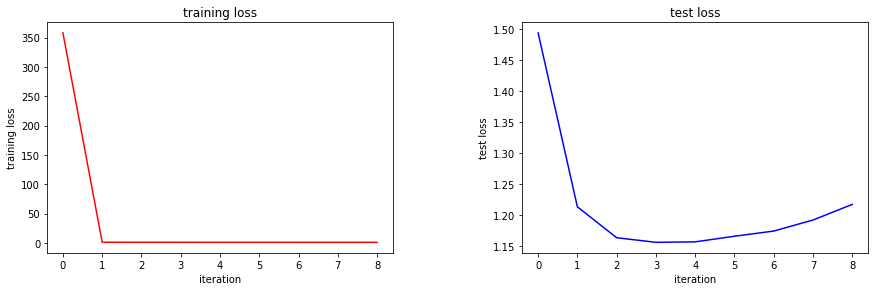

In [0]:
test_loss_plt = [1.4942535, 1.2132678, 1.1633137, 1.1558896, 1.1566725, 1.1657099, 1.1741136, 1.191923, 1.2171673]
train_loss_plt = [358.06757, 1.3802097, 1.2618506, 1.2162862, 1.1912273, 1.1947932, 1.1734571, 1.161564, 1.138844]
iteration = range(0,9)
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
axes1.plot(iteration,train_loss_plt,'r')
axes1.set_title("training loss")
axes1.set_xlabel("iteration")
axes1.set_ylabel("training loss")

axes2 = fig.add_axes([1.2,0.1,0.8,0.8])
axes2.plot(iteration,test_loss_plt,'b')
axes2.set_title("test loss")
axes2.set_xlabel("iteration")
axes2.set_ylabel("test loss")

# Integrating ***csv*** file Metadata as I want to use it  in model training.

Age preprocessing first. Age is blank on many places and having 0 as an age value and should be handled in below mwntioned fashion.

# Approach:
1. First replace all unknown values with 0.
2. Replace 0 with mean age of male in case sex is male.
3. Replace 0 with mean age of female in case sex is female.
4. Replace 0 with mean age of male+female  in case sex is unknown.
5. And normalize the age in the last for faster model training.
6. Dump the minMaxscaler model


In [0]:
#processing metadata file for model training

def age_preprocessing(metaData):
    '''
    age and its issue:
    1. Some of the values are blank.
    2. Some of the age are zero
    '''
    metaData['age_p'] = metaData['age']

    #taking mean age of male, female
    mean_age_male = int(np.mean(metaData[metaData["sex"] == 'male']['age']))
    mean_age_female = int(np.mean(metaData[metaData["sex"] == 'female']['age']))


    #Initially replacing missing value with 0 using Imputer class
    imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 0)
    age = metaData['age_p'].values
    age = imp.fit_transform(age.reshape(-1,1))
    metaData['age_p'] = age

    #Replacing 0 age for male with mean male age
    age = metaData[(metaData["sex"] == 'male') & (metaData['age_p'] == 0)]['age_p']
    for i in age.index:
        metaData.at[i,'age_p'] = mean_age_male

    #Replacing 0 age for female with mean female age
    age = metaData[(metaData["sex"] == 'female') & (metaData['age_p'] == 0)]['age_p']
    for i in age.index:
        metaData.at[i,'age_p'] = mean_age_female

    #Replacing 0 age for unknown sex with mean age of both the sex
    age = metaData[(metaData["sex"] == 'unknown') & (metaData['age_p'] == 0)]['age_p']
    for i in age.index:
        metaData.at[i,'age_p'] = int((mean_age_female+mean_age_male)/2)

    minMaxScaler = MinMaxScaler(feature_range = (-1,1))
    minMaxScaler.fit(metaData['age_p'].values.reshape(-1,1))
    age=minMaxScaler.transform(metaData['age_p'].values.reshape(-1,1))
    pk.dump(minMaxScaler,open("minMaxScaler.pkl","wb"))
    metaData.drop(columns=['age_p'], inplace = True)
    return age

Converting rest of the metadata categorical features in to one hot encoding.
# Saving all the models as pickle file.

In [0]:
def convertingStringtoNumerical(metaData):    
    #One hot Encoding Categorical features
    ohe_dx_type = OneHotEncoder(sparse=False)
    ohe_sex = OneHotEncoder(sparse=False)
    ohe_dx_localization = OneHotEncoder(sparse=False)
    
    dx_type = ohe_dx_type.fit_transform(metaData['dx_type'].values.reshape(-1,1))
    sex = ohe_dx_type.fit_transform(metaData['sex'].values.reshape(-1,1))
    localization = ohe_dx_type.fit_transform(metaData['localization'].values.reshape(-1,1))
    
    pk.dump(ohe_dx_type,open("ohe_dx_type.pkl","wb"))
    pk.dump(ohe_sex,open("ohe_sex.pkl","wb"))
    pk.dump(ohe_dx_localization,open("ohe_dx_localization.pkl","wb"))
    
    return dx_type, sex, localization

Cocatenating all the meta data and saving back again to csv file.

In [0]:
age = age_preprocessing(metaData)
dx_type, sex, localization = convertingStringtoNumerical(metaData)


features_fromMetaData = np.concatenate((age,dx_type,sex,localization), axis = 1)

df = pd.DataFrame(data=features_fromMetaData[0:,0:])
metaData = pd.concat([metaData, df],axis=1)
df_train, df_test = train_test_split(metaData, test_size=0.1, random_state=786, stratify=y)


In [0]:
metaData.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization,encoded_dx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0.875,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0.875,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0.875,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0.875,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0.750,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# New batch method, that will return meta data as well.

### Assumption images exist in images folder.

In [0]:
def get_batch_with_metadata(df, batch_size, transformation = False):
    """
    tranformation: Set as False just to get the original image. Tried to run,
    but observed memory issue. Set can set as True and reduced scale  by 1/4.
    
    
    
    """
    for batch_i in range(0, 1 + (df.shape[0] //batch_size)):
        start_i = batch_i * batch_size
        try:
            batch = df.iloc[start_i:start_i + batch_size]    
        except IndexError:
            batch = df.loc[start_i:]
            
        image_list  = [] 
        label = []
        metaDataFeatures = []
        
        for i in range(batch.shape[0]):
            imageFileName = batch.iloc[i]['image_id']
        
            try:
                img = io.imread('images/'+imageFileName+".jpg", plugin='matplotlib')
                #if(450 != img.shape[0] or 600 != img.shape[1]):
                #  img = transform.resize(img, (450, 600),anti_aliasing=True)
                
                if True == transformation:
                    img = transform.rescale(img, 0.25, anti_aliasing=True)
                    #Recommended to use anti_aliasing as True just to have crisp boundaries of the image.
                image_list.append(img/255)
                label.append(batch.iloc[i]['encoded_dx'])
                metaDataFeatures.append(batch.iloc[i,8:])
            
            except IOError:
                pass
        yield np.array(image_list), np.array(label), np.array(metaDataFeatures)   

Defininigg new model_input method, that will return .csv file **processed meta data** along with other relevant information required for model training.

In [0]:
def modelInputs_for_Metadata(height, width, chanels):
    '''Create palceholders for inputs to the model'''
    features = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="features")   
    metaDataFeatures = tf.placeholder(tf.float32, shape=[None, 23], name="metaDataFeatures")
    target = tf.placeholder(tf.int32, shape=[None], name="target")
    lr = tf.placeholder(tf.float32, name='lr')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    is_model_training = tf.placeholder(tf.bool, name = "is_model_training")
    return features, metaDataFeatures, target, lr, keep_prob, is_model_training

# Needs to redefine convLayers just to integrate meta data info.

In [0]:
def convLayersWithPooling_for_Metadata(features, metaDataFeatures, keep_prob, conv1_FiltersCount, 
                          conv2_FiltersCount, conv1_filterSize, conv2_filterSize,
                          conv1_stride, conv2_stride, conv1_pad, conv2_pad, denseLayerNeurons, 
                          outputSize, isTraining):
    with tf.name_scope("ConvLayers"):
        conv1 = tf.layers.conv2d(features, filters=conv1_FiltersCount, kernel_size=conv1_filterSize,
                                 strides=conv1_stride, padding=conv1_pad, activation=tf.nn.relu, 
                                 name="conv1")
        conv2 = tf.layers.conv2d(conv1, filters=conv2_FiltersCount, kernel_size=conv2_filterSize,
                                 strides=conv2_stride, padding=conv2_pad, activation=tf.nn.relu, 
                                 name="conv2")
        
    with tf.name_scope("Pooling"):
        layer3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        layer3_reshaped = tf.reshape(layer3, shape=[-1, layer3.shape[1]* layer3.shape[2]* layer3.shape[3]])
        #Concatenaed MetaData with CNN layer output, just before the dense layer.
        concatenated_data = tf.concat([layer3_reshaped, metaDataFeatures], 1)
        
    with tf.name_scope("DenseLayer"):
        layer4 = tf.layers.dense(concatenated_data, denseLayerNeurons, activation=tf.nn.relu, name="fc")
        dropout = tf.layers.dropout(inputs=layer4, rate=keep_prob, training=isTraining)
        
    with tf.name_scope("output"):
        logits = tf.layers.dense(dropout, outputSize, name="output")
        print("logits:",logits)
        
    return logits

# No Change in optimizer part.,

In [0]:
tf.reset_default_graph()
features, metaDataFeatures, target, lr, keep_prob, is_model_training = modelInputs_for_Metadata(height, width, channels)

logits = convLayersWithPooling_for_Metadata(features, metaDataFeatures, keep_prob, conv1_FiltersCount, conv2_FiltersCount, 
                               conv1_filterSize, conv2_filterSize,conv1_stride, conv2_stride, 
                               conv1_pad, conv2_pad, denseLayerNeurons, outputSize, is_model_training)
loss, training_op, accuracy = optmizationWithAccuracy(logits, target, lr)

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


logits: Tensor("output/output/BiasAdd:0", shape=(?, 7), dtype=float32)
xentropy: Tensor("train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
loss: Tensor("train/Mean:0", shape=(), dtype=float32)


In [0]:
with tf.Session() as sess:
    earlyStop = 0
    init.run()
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(n_epochs):
        count = 0
        epochlosses = []
        accuracy = []
        print("\n***************************************************************epoch:",epoch)
        for i, (X_image, y_label, X_metadata) in enumerate(get_batch_with_metadata(df_train, batch_size, False)):
            #print(X_image.shape, y_label.reshape(-1))
            
            losses, op, correctness = sess.run((loss, training_op, accuracy), 
                                               feed_dict={features: X_image, 
                                                          metaDataFeatures: X_metadata,
                                                          target:y_label.reshape(-1),
                                                          lr:learning_rate,
                                                          keep_prob:k_prob,
                                                          is_model_training:True})
            epochlosses.append(losses)
            accuracy.append(correctness)            
            if count == 50:
                break
            count = count+1
            
        train_loss.append(np.mean(epochlosses)) 
        train_accuracy.append(np.mean(accuracy))
        # Reducing learning rate for more gannualar results. Though, it will 
        #make training bit slow.
        print("learning_rate", learning_rate)
        learning_rate = np.max([learning_rate * invscaling_factor, min_lr_threshold])
        print("learning_rate", learning_rate)
        
        total_test_loss = []
        accuracy = []
        #print("train loss:", train_loss)
        count = 0
        for i, (X_image, y_label, X_metadata) in enumerate(get_batch_with_metadata(df_test, 15, False)):
            losses, acc = sess.run((loss,accuracy), feed_dict={features: X_image, 
                                               metaDataFeatures: X_metadata,
                                               target:y_label.reshape(-1),
                                               keep_prob:1,
                                               is_model_training:False})    

            total_test_loss.append(losses)
            accuracy.append(acc)
            if count == 5:
                break
            count = count+1
        print("tarin_loss:", np.mean(epochlosses), "    test loss:",np.mean(total_test_loss))    
        
        test_loss.append(np.mean(total_test_loss))
        test_accuracy.append(np.mean(accuracy))
        #print("test loss:", test_loss)
        if np.mean(total_test_loss) <= np.min(test_loss):
            print("improving")
            earlyStop = 0
            saver = tf.train.Saver() 
            #saver.save(sess, checkpoint)

        else:
            print("No Improvement.")
            earlyStop += 1
            if earlyStop == threshold:
                print("no improvement and terminating")
                break

# Result capture for 10 epochs. For PoC, captured result for partial data and dont run for the whole set.

Text(0, 0.5, 'test loss')

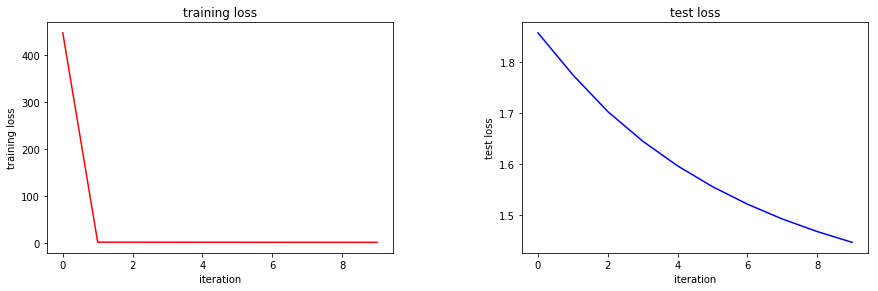

In [0]:
test_loss_plt = [1.8566809, 1.774573, 1.7028137, 1.6450186, 1.5966746, 1.5560867, 1.5218773, 1.4929241, 1.4683124, 1.4472984]
train_loss_plt = [447.05408, 1.8138844, 1.736963, 1.6728997, 1.6194909, 1.5747224, 1.5370576, 1.5052423, 1.4782546, 1.4552612]
iteration = range(0,10)
fig = plt.figure()
axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
axes1.plot(iteration,train_loss_plt,'r')
axes1.set_title("training loss")
axes1.set_xlabel("iteration")
axes1.set_ylabel("training loss")

axes2 = fig.add_axes([1.2,0.1,0.8,0.8])
axes2.plot(iteration,test_loss_plt,'b')
axes2.set_title("test loss")
axes2.set_xlabel("iteration")
axes2.set_ylabel("test loss")